In [26]:
import numpy as np
import sys
import os
import fnmatch
sys.path.append('../')
import base as base
import path_analysis
import matplotlib.pyplot as plt
import pandas as pd
import datetime
processed= 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/processed/straightness/'

## Goal

The purpose of this notebook is to explore Jin's code with open base and path analysis and eventually be able to plot and perphaps first export the straigntess analysis - here again the idea is to analyze the straightness before the beacon - about 5 seconds and compare it to sham. So there should be for each animal perhaps for each 5 seconds before beacon some numbers can then compare them to across sessions. Should have a plot simliar to the rearing - But here it is instantanous straightness 

### 1. Load one session
2. Plot trajectory for one trial/ beacon 
3. Calculate straightness for time before the beacon 
4. Plot the straightness 5 seconds back
5. Separate for visible and invisible beacon - use meatdata 
6. Repeat for more then 2 sessions 
7. Run averages for perhaps 10 sessions each 
8. Calculate bootstrapped 

# 1. Load one session 

In [2]:
# root = '//10.153.170.3/storage2/fabian/data/project/FS11/Training/BPositions_FS11_20211006-161633'
# tag = '20211006-161633'

In [27]:
root = '/mnt/c/Users/megla/OneDrive/Documents/TUM/RatAnalysis/Multiple_trial_analysis/Data/Raw/FS10/BPositions_FS10_20211006-154014'
tag = '20211006-154014'

In [28]:
FS10_one = base.BeaconPosition(root, tag, has_beacon=True, has_metadata=True)

/home/mlane/anaconda3/envs/ratanalysis/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [29]:
FS10_one.metadata

,Recording started on,Computer time was,ITI_time,time_in_cylinder,movement_collection_time,animal_ID,background_color,circle,position_change,light_off,...,recording lenght,high pellets,high_time_in_cylinder,invisible_time,invisible_count,invisible_list,Animal jumped,Recording_started_motive,Recording_timestamp_motive,Day
1,2021-10-06 15:40:14,1633527614.36,1.5,1.5,0.01,FS10,000,0.075,1000,200,...,1814.625,20,0.5,60,0,[],-1,0,0.0,156


## Show one trial with beacon

[-0.15904586 -0.52945693]


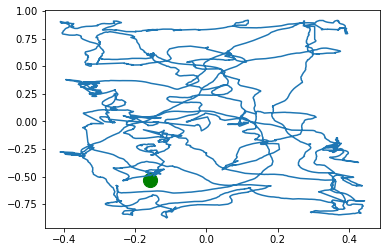

In [30]:
plt.plot(FS10_one.trial_list[2][2000:-1,1],FS10_one.trial_list[2][2000:-1,2] )
print(FS10_one.trial_beacon[2])

plt.scatter(FS10_one.trial_beacon[2][0],FS10_one.trial_beacon[2][1],c="green",s=200)
plt.show()

In [31]:
print(len(FS10_one.trial_list))
# Does this mean there are 27 trials?

27


## Print when session started and compare to when first trial if marked - started in metadata when pressed start - so not when animal lowered in

In [10]:
time = FS10_one.metadata["Computer time was"]
lasted = float(FS10_one.metadata["recording lenght"][1])
print (float(time[1]))
print(datetime.datetime.fromtimestamp(float(time[1])).strftime('%c'))
print(datetime.datetime.fromtimestamp(lasted + float(time[1])).strftime('%c'))

1633527614.36
Wed Oct  6 15:40:14 2021
Wed Oct  6 16:10:28 2021


## Print first and last time from the segmented trials 

In [11]:
time = FS10_one.trial_list[0][:,:1][0]
last =  FS10_one.trial_list[-1][:,:1][-1]
print(print(datetime.datetime.fromtimestamp(time[0]).strftime('%c')))
print(print(datetime.datetime.fromtimestamp(last[0]).strftime('%c')))

Wed Oct  6 15:40:26 2021
None
Wed Oct  6 16:10:27 2021
None


## Beginning of the first trial is likely the entry of the rat inside of arena - hence need to measure straightness from the last time of the trial 

In [12]:
straightness_time = path_analysis.straightness_over_time(FS10_one.trial_list[2][-300:-1,:3], time_window=4)
straightness_time2 = path_analysis.straightness_over_time(FS10_one.trial_list[2][:,:3], time_window=4)

In [14]:
# straightness_time[2][:,1]

[-0.15904586 -0.52945693]


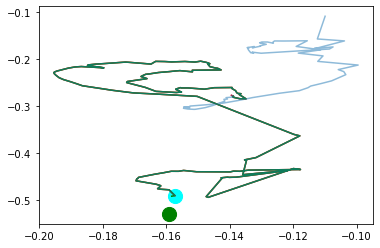

In [16]:
plt.plot(straightness_time[2][:,0],straightness_time[2][0:,1],c="red")
plt.plot(straightness_time2[2][:,0],straightness_time2[2][0:,1],c="green")
plt.plot(FS10_one.trial_list[2][-300:-1,1],FS10_one.trial_list[2][-300:-1,2],alpha= .5)
print(FS10_one.trial_beacon[2])

plt.scatter(FS10_one.trial_beacon[2][0],FS10_one.trial_beacon[2][1],c="green",s=200)
plt.scatter(FS10_one.trial_list[2][-2:-1,1],FS10_one.trial_list[2][-2:-1,2],c="cyan",s= 200)
plt.show()

# Above - showing that if I measure the last 300 samples and their straightness, it will be till the end of the trial - becasue I plot the postions from the straightness_time - Hence I can use the straightness measure as it counts it backwards for the beacon and I just need to flip the the axis at the end. 

### Problem is that trial segmentation is done only as invisible successful visible or invisible successful. - But I anyways need to index only to either 0 - visible or 2 invisible successful  

Wed Oct  6 15:45:05 2021
None


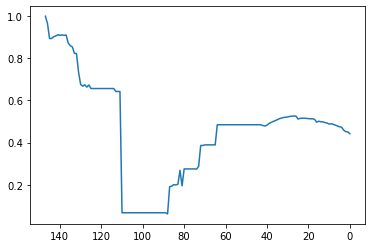

In [17]:
straightness_time = path_analysis.straightness_over_time(FS10_one.trial_list[2][:,:3], time_window=3)
time = FS10_one.trial_list[2][:,:1][0]
print(print(datetime.datetime.fromtimestamp(time[0]).strftime('%c')))
plt.plot(straightness_time[0], )
plt.gca().invert_xaxis()

# Now show all straightness from the last 4 seconds in all trials in the first session 

# trial_visible: list of booleans referring visibility of trial (0 - visible, 1 - successful invisible, 2 - failed invisible )

## Now plot with averages as well 

In [105]:
# Discard trials that are too short - return None if trajectory was too short for time window

def straightness_over_time(trial_trajectory, time_window=2):

    straightness = []

    def _straight_line(start, end, length):

        _x = np.linspace(start[0], end[0], length)
        _y = np.linspace(start[1], end[1], length)

        return np.vstack([_x, _y]).T

    def _straight_length(start, end):

        return np.sqrt(np.sum((start - end)**2))

    def travel_distance(traj):
        return np.cumsum(np.sqrt(np.sum((traj[1:] - traj[:-1])**2,
                                        axis=1)))[-1]

    time = trial_trajectory[:, 0]


    time_after = np.cumsum(np.flip(time[1:] - time[:-1]))
    trajectory_ = np.flip(trial_trajectory[:, 1:3, ],
                            axis=0)

    if time_window is None:
        end_ind = -1
        trial_trajectory = trajectory_[:end_ind]
    elif time_after[-1] > time_window:
        end_ind = np.where(time_after > time_window)[0][0]
        trial_trajectory = trajectory_[:end_ind]
    else:
        print('Time window exceeds the length of trajectory for this trial. Straightness will not be computed.')
        return None, None, None

    for i in range(len(trial_trajectory) - 2):
        straight_length = _straight_length(trial_trajectory[i + 1],
                                           trial_trajectory[0])
        trajectory_displacement = travel_distance(trial_trajectory[:i + 2])

        straightness.append(straight_length / trajectory_displacement)

    return np.flip(straightness), (trial_trajectory[0],
                          trial_trajectory[-1]), trial_trajectory

Time window exceeds the length of trajectory for this trial. Straightness will not be computed.


/tmp/ipykernel_384/2512552368.py:44: RuntimeWarning: invalid value encountered in double_scalars
  straightness.append(straight_length / trajectory_displacement)
/tmp/ipykernel_384/2273762820.py:36: RuntimeWarning: Mean of empty slice
  average_invis = np.nanmean(invisible,axis=1)


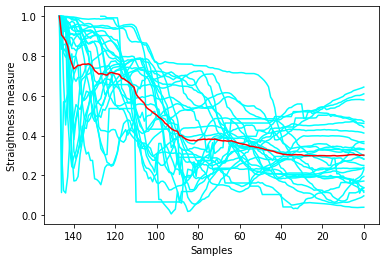

In [110]:
# This example has only visible trials
WIN_SIZE = 3 # Take 3 s segments

# Get the length of the straightness outputs
tmp_straightness, _, _ = straightness_over_time(FS10_one.trial_list[0], time_window=WIN_SIZE)

trial_num = len(FS10_one.trial_list[:])

# Initialize storing the trials by visible/invsible
visible=np.nan*np.ones((len(tmp_straightness),trial_num)) # NaNs in shape (3 seconds = 148 samples, num_trials)
invisible=np.nan*np.ones((len(tmp_straightness),trial_num)) # NaNs in shape (3 seconds = 148 samples, num_trials)

# Loop through all trials
for i in range(len(FS10_one.trial_list)):
    
    # Returns (straightness metric, (start & end of trajectory), trajectory)
    straightness_metric, trajectory_pts, trajectory = \
    straightness_over_time(FS10_one.trial_list[i], time_window=WIN_SIZE)
    
    if straightness_metric is None: 
        continue
        
    else:

        # If successful invisible, store the straightness measure
        if FS10_one.trial_visible[i]:
            plt.plot(straightness_metric)
            invisible[:,i] = straightness_metric

        # Otherwise if visible, store the straightness measure
        else:
            plt.plot(straightness_metric, c='cyan')
            visible[:,i] = straightness_metric
    
average_vis = np.nanmean(visible,axis=1)
average_invis = np.nanmean(invisible,axis=1)

plt.plot(average_vis, c='red')
plt.plot(average_invis, c='black')
plt.xlabel('Samples')
plt.ylabel('Straightness measure')
plt.gca().invert_xaxis()

# 2. Load more than 1 session

In [16]:
def Make_tags (rat_ID="FS11"):
    """Takes in animal ID and searches through a specific subfolder in storage 2 to generate time tags for each session
    
    PARAMS
    ------------
    rat_ID : str
        name of animal
    
    Returns
    ------------
    list of str of roots and list of str of tags - date time   
    
    """
    animal= '//10.153.170.3/storage2/fabian/data/project/'+rat_ID 
    dirnames = [ name for name in os.listdir(animal) if os.path.isdir(os.path.join(animal, name)) ]   
    roots = [k for k in dirnames if 'BP' in k]
    filter_tags = [x[-15:] for x in roots]
    filter_roots = [animal + s for s in roots]
    return filter_roots, filter_tags, 
root, tags = Make_tags ("FS11/Training/")

In [19]:
np.size(root)
print(root[0:5])
print(tags[0:5])
print(len(root))


['//10.153.170.3/storage2/fabian/data/project/FS11/Training/BPositions_FS11_20211006-161633', '//10.153.170.3/storage2/fabian/data/project/FS11/Training/BPositions_FS11_20211007-142813', '//10.153.170.3/storage2/fabian/data/project/FS11/Training/BPositions_FS11_20211011-102330', '//10.153.170.3/storage2/fabian/data/project/FS11/Training/BPositions_FS11_20211014-163731', '//10.153.170.3/storage2/fabian/data/project/FS11/Training/BPositions_FS11_20211015-175713']
['20211006-161633', '20211007-142813', '20211011-102330', '20211014-163731', '20211015-175713']
88


In [18]:
FS11 = base.MultiDaysBeaconPosition(root[0:5], tags[0:5], has_beacon = True, has_metadata= True)

20211006-161633


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20211007-142813


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20211011-102330


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20211014-163731


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20211015-175713


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


In [20]:
FS11.dataset_list[1].beacon_data

array([[ 1.63361003e+09, -1.59045861e-01, -5.29456926e-01],
       [ 1.63361032e+09, -1.59045861e-01, -5.29456926e-01],
       [ 1.63361038e+09, -2.48865120e-01,  7.34667226e-01],
       [ 1.63361046e+09, -2.48865120e-01,  7.34667226e-01],
       [ 1.63361049e+09, -2.52951041e-01, -2.55863060e-02],
       [ 1.63361056e+09, -2.52951041e-01, -2.55863060e-02],
       [ 1.63361061e+09,  1.99776237e-01, -4.28890912e-01],
       [ 1.63361063e+09,  1.99776237e-01, -4.28890912e-01],
       [ 1.63361072e+09, -1.34980767e-01,  4.15106102e-01],
       [ 1.63361094e+09, -1.34980767e-01,  4.15106102e-01],
       [ 1.63361096e+09,  2.92020227e-01, -7.03357002e-01],
       [ 1.63361103e+09,  2.92020227e-01, -7.03357002e-01],
       [ 1.63361123e+09, -9.92367795e-02, -3.62636841e-01]])

In [21]:
FS11.dataset_list[1].displacement

array([0.00751276, 0.00375954, 0.00610914, ..., 0.00032921, 0.00017164,
       0.00035288])

In [22]:
FS11.dataset_list[1].trial_beacon

array([[-0.15904586, -0.52945693],
       [-0.15904586, -0.52945693],
       [-0.24886512,  0.73466723],
       [-0.24886512,  0.73466723],
       [-0.25295104, -0.02558631],
       [-0.25295104, -0.02558631],
       [ 0.19977624, -0.42889091],
       [ 0.19977624, -0.42889091],
       [-0.13498077,  0.4151061 ],
       [-0.13498077,  0.4151061 ],
       [ 0.29202023, -0.703357  ],
       [ 0.29202023, -0.703357  ],
       [-0.09923678, -0.36263684]])

In [23]:
# Time of the trial 
one = FS11.dataset_list[1].trial_list[0][1][0]
np.shape(FS11.dataset_list[1].trial_list)
my_time=datetime.datetime.fromtimestamp(one).strftime('%c')
my_time

D:\Software\anaconda\envs\project\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


'Thu Oct  7 14:28:37 2021'

In [24]:
FS11.trial_list[1][1][:,:1]


array([[1.63361003e+09],
       [1.63361003e+09],
       [1.63361003e+09],
       ...,
       [1.63361032e+09],
       [1.63361032e+09],
       [1.63361032e+09]])

In [25]:
for time in FS11.trial_list[0][1][:,:3][0:5]:
    print(datetime.datetime.fromtimestamp(time[0]).strftime('%c'))

Wed Oct  6 16:19:23 2021
Wed Oct  6 16:19:23 2021
Wed Oct  6 16:19:23 2021
Wed Oct  6 16:19:23 2021
Wed Oct  6 16:19:23 2021


In [26]:
FS11.trial_list[1][1][:,:3]

array([[ 1.63361003e+09, -9.82588583e-02, -5.18211448e-01],
       [ 1.63361003e+09, -9.76944822e-02, -5.19502553e-01],
       [ 1.63361003e+09, -9.49423459e-02, -5.17282477e-01],
       ...,
       [ 1.63361032e+09, -2.07479088e-01, -5.23433341e-01],
       [ 1.63361032e+09, -2.07479088e-01, -5.23433341e-01],
       [ 1.63361032e+09, -2.07479088e-01, -5.23433341e-01]])

In [27]:
#Looks at straightness only for one moment
#show straightness over the whole time as said 
straightness_time = path_analysis.straightness_over_time(FS11.trial_list[0][1][:,:3], time_window=3)

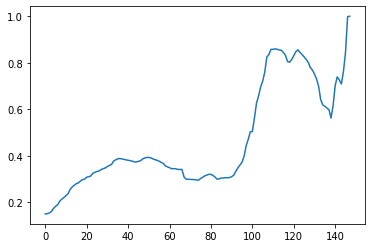

In [28]:
plt.plot(straightness_time[0], )

..\path_analysis.py:89: RuntimeWarning: invalid value encountered in double_scalars
  straightness.append(straight_length / trajectory_displacement)
<ipython-input-72-70a5aa8a473a>:27: RuntimeWarning: Mean of empty slice
  average_vis = np.nanmean(visible,axis=1)
<ipython-input-72-70a5aa8a473a>:29: RuntimeWarning: Mean of empty slice
  average_invis = np.nanmean(invisible,axis=1)
..\path_analysis.py:89: RuntimeWarning: invalid value encountered in double_scalars
  straightness.append(straight_length / trajectory_displacement)
<ipython-input-72-70a5aa8a473a>:27: RuntimeWarning: Mean of empty slice
  average_vis = np.nanmean(visible,axis=1)
<ipython-input-72-70a5aa8a473a>:29: RuntimeWarning: Mean of empty slice
  average_invis = np.nanmean(invisible,axis=1)
..\path_analysis.py:89: RuntimeWarning: invalid value encountered in double_scalars
  straightness.append(straight_length / trajectory_displacement)
<ipython-input-72-70a5aa8a473a>:27: RuntimeWarning: Mean of empty slice
  average_vis

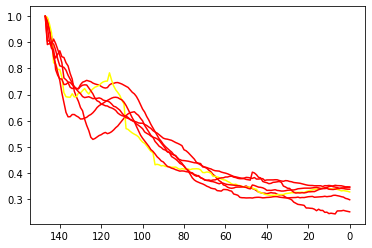

In [72]:
straightness_list_vis = []
straightness_list_invis = []
for k in range (len(FS11.trial_list)):
    trial_num = len(FS11.trial_list[k][:])
    visible=np.nan*np.ones((250,trial_num))
    invisible=np.nan*np.ones((250,trial_num))
    for i in range(len(FS11.trial_list[k])):
#         print(np.shape(FS11.trial_list[k][i][:,:3])[0])
        if np.shape(FS11.trial_list[k][i][:,:3])[0]<150: 
            straightness_time = path_analysis.straightness_over_time(FS11.trial_list[k][i][:,:3], time_window=1)
        else:
            straightness_time = path_analysis.straightness_over_time(FS11.trial_list[k][i][:,:3], time_window=3)
        

        if FS11.trial_visible[k][i]:
#             print(FS11.trial_visible[k][1])
#             plt.plot(straightness_time[0])
            invisible[:len(straightness_time[0]),i]=straightness_time[0]
    #         plt.gca().invert_xaxis()
        else:
#             plt.plot(straightness_time[0],c='cyan')
    #         plt.gca().invert_xaxis()
    #         print(straightness_time[0])
            visible[:len(straightness_time[0]),i]=straightness_time[0]
    #         np.concatenate(visible,np.array(straightness_time[0]) )
#     print(average_vis )
    average_vis = np.nanmean(visible,axis=1)
    straightness_list_vis.append(average_vis)
    average_invis = np.nanmean(invisible,axis=1)
    straightness_list_invis.append(average_invis)
    
    plt.plot(average_vis,c='red')
    plt.plot(average_invis,c='yellow')
    plt.gca().invert_xaxis()
np.save(processed +'%s_straightness_FS11_visible',average_vis)
np.save(processed +'%s_straightness_FS11_invisible',straightness_list_invis)

# Generate and save average per session per animal - might need to seperate due to memory issues. 

# Plot and save per animal 

In [17]:
def plot_safe_per_animal (animal,save):

    root, tags = Make_tags (animal)
    print(len(tags))
    FS11 = base.MultiDaysBeaconPosition(root[0:44], tags[0:44], has_beacon = True, has_metadata= True)
    
    straightness_list_vis = []
    straightness_list_invis = []

    for k in range (len(FS11.trial_list)):
        trial_num = len(FS11.trial_list[k][:])
        visible=np.nan*np.ones((260,trial_num))
        invisible=np.nan*np.ones((260,trial_num))
        for i in range(len(FS11.trial_list[k])):
    #         print(np.shape(FS11.trial_list[k][i][:,:3])[0])
    
            if np.shape(FS11.trial_list[k][i][:,:3])[0]<260: 
                continue
            else:
                straightness_time = path_analysis.straightness_over_time(FS11.trial_list[k][i][:,:3], time_window=5)


            if FS11.trial_visible[k][i]:
    #             print(FS11.trial_visible[k][1])
    #             plt.plot(straightness_time[0])
                invisible[:len(straightness_time[0]),i]=straightness_time[0]
        #         plt.gca().invert_xaxis()
            else:
    #             plt.plot(straightness_time[0],c='cyan')
        #         plt.gca().invert_xaxis()
        #         print(straightness_time[0])
                visible[:len(straightness_time[0]),i]=straightness_time[0]
        #         np.concatenate(visible,np.array(straightness_time[0]) )
    #     print(average_vis )
        average_vis = np.nanmean(visible,axis=1)
        straightness_list_vis.append(average_vis)
        average_invis = np.nanmean(invisible,axis=1)
        straightness_list_invis.append(average_invis)

        plt.plot(average_vis,c='red')
        plt.plot(average_invis,c='yellow')
        plt.gca().invert_xaxis()
    np.save(processed +'%s_straightness_visible'%(save) ,straightness_list_vis)
    np.save(processed +'%s_straightness_invisible'%(save),straightness_list_invis)

# plot_safe_per_animal (animal ="FS10/Training/",save= "FS10_training")

In [48]:
FS11_vis= np.load(processed +'FS11_training_straightness_visible.npy')

In [49]:
FS11_vis[1]

array([0.34426755, 0.34410582, 0.34480007, 0.34687839, 0.34660931,
       0.34726421, 0.34821017, 0.34721119, 0.34726076, 0.34616459,
       0.34551213, 0.34349465, 0.34322272, 0.34288164, 0.34120728,
       0.33990354, 0.33799073, 0.33501014, 0.33453604, 0.3320559 ,
       0.33072244, 0.32820157, 0.32636512, 0.3248065 , 0.32203068,
       0.3197445 , 0.31860726, 0.31543931, 0.31367688, 0.31010343,
       0.30789284, 0.30566878, 0.30378933, 0.30226302, 0.29787876,
       0.29573358, 0.29504886, 0.29266986, 0.29224819, 0.28898217,
       0.28819077, 0.28634373, 0.28864004, 0.28858045, 0.28656539,
       0.28540047, 0.2856718 , 0.28541742, 0.28397233, 0.28145325,
       0.28051222, 0.27999302, 0.2796652 , 0.2792708 , 0.27624727,
       0.2867934 , 0.28607028, 0.28517339, 0.28532619, 0.27875053,
       0.27705837, 0.2674283 , 0.26503706, 0.26265367, 0.26873408,
       0.26767383, 0.26401675, 0.25946043, 0.255989  , 0.25160887,
       0.24860159, 0.24677996, 0.24460601, 0.24014025, 0.23695

## FS11 done but only part way - as thewere was a double scalars bug - similiar with FS10 

22
20210112-180433


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201125-185930


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201201-173129


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201202-181328


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201203-214652


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201208-223904


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201209-120834


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201211-175842


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201212-210900


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201213-215429


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201217-171209


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201217-172420


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201218-202333


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201220-174618


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201221-122943


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201221-211412


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201222-144948


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201222-214912


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201223-125151


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201223-205556


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20210111-163449


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T


20201127-182125


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\path_analysis.py:89: RuntimeWarning: invalid value encountered in double_scalars
  straightness.append(straight_length / trajectory_displacement)
<ipython-input-17-07f9a373cf47>:35: RuntimeWarning: Mean of empty slice
  average_vis = np.nanmean(visible,axis=1)
<ipython-input-17-07f9a373cf47>:37: RuntimeWarning: Mean of empty slice
  average_invis = np.nanmean(invisible,axis=1)
<ipython-input-17-07f9a373cf47>:35: RuntimeWarning: Mean of empty slice
  average_vis = np.nanmean(visible,axis=1)
<ipython-input-17-07f9a373cf47>:37: RuntimeWarning: Mean of empty slice
  average_invis = np.nanmean(invisible,axis=1)
..\path_analysis.py:89: RuntimeWarning: invalid value encounte

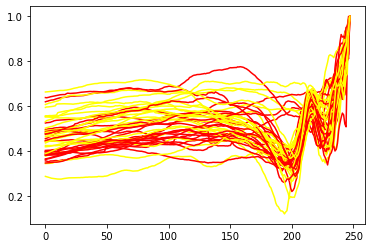

In [20]:
# plot_safe_per_animal (animal ="FS10/Training/",save= "FS10_training")
# plot_safe_per_animal (animal ="FS09/Training/",save= "FS09_training")
# plot_safe_per_animal (animal ="FS08/Training/",save= "FS08_training")

# plot_safe_per_animal (animal ="FS06_new/",save= "FS06_training")
# # plot_safe_per_animal (animal ="FS05",save= "FS05_training") - will need to change offsets 
# plot_safe_per_animal (animal ="FS04_new/",save= "FS04_training")
plot_safe_per_animal (animal ="FS03_new/",save= "FS03_training")


97


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling

66


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling

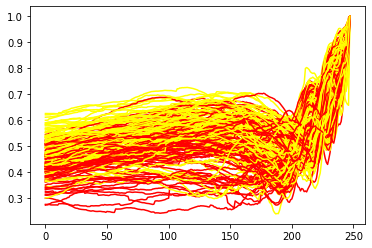

In [44]:
# plot_safe_per_animal (animal ="FS07",save= "FS07_training")
# plot_safe_per_animal (animal ="FS10/Training/",save= "FS10_training")
# plot_safe_per_animal (animal ="FS09/Training/",save= "FS09_training")

# Petrubations : DONE ALL 

In [ ]:
# plot_safe_per_animal (animal ="FS11/Vestibular/",save= "FS11_vestibular")
# plot_safe_per_animal (animal ="FS10/Vestibular/",save= "FS10_vestibular") #- gives error - for trial list 
# plot_safe_per_animal (animal ="FS09/Vestibular/",save= "FS09_vestibular")
# plot_safe_per_animal (animal ="FS08/Vestibular/",save= "FS08_vestibular")

5


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling

3


..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\base.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(p, sep=" : ", header=None, index_col=0).T
..\path_analysis.py:89: RuntimeWarnin

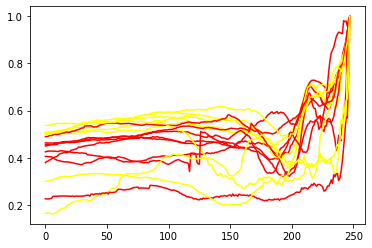

In [30]:
# plot_safe_per_animal (animal ="FS11/Visual/",save= "FS11_visual") #last one had metadata but decided to cut it as it was not stopped porperly
# plot_safe_per_animal (animal ="FS10/Visual/",save= "FS10_visual")
# plot_safe_per_animal (animal ="FS09/Visual/",save= "FS09_visual")
# plot_safe_per_animal (animal ="FS08/Visual/",save= "FS08_visual")

## Current problem is that trials can be very short so need to assign a different lenght for time window in each case. - Solved with trial sizes 

## Now Bootstrapping - DONE - thanks JIN! - not sure if it pick random trajectories or not

In [65]:
bootstrap_sliding_window=path_analysis.bootstrap(FS11.trial_list[0][0], num_sampling=1000, time_window=3, straightness_type = 'sliding')

In [25]:
bootstrap_sliding_window=path_analysis.bootstrap(FS10_one.trial_list[0], num_sampling=1000, time_window=3, straightness_type = 'sliding')

/mnt/c/Users/megla/OneDrive/Documents/TUM/RatAnalysis/Multiple_trial_analysis/refactoring/demo_notebook/../path_analysis.py:89: RuntimeWarning: invalid value encountered in double_scalars
  straightness.append(straight_length / trajectory_displacement)


In [66]:
np.save(processed +'%s_shuffle_10000_straightness',bootstrap_sliding_window)
bootstrap_sliding_window[0]

array([0.54639544, 0.5482668 , 0.55253051, 0.55475175, 0.56060232,
       0.56741141, 0.57250009, 0.57560113, 0.57560113, 0.58539554,
       0.58539554, 0.5879815 , 0.5879815 , 0.59556752, 0.6075322 ,
       0.61159208, 0.61159208, 0.61159208, 0.62979993, 0.65235188,
       0.65988628, 0.662756  , 0.67543559, 0.68860738, 0.700065  ,
       0.700065  , 0.71346358, 0.71346358, 0.7462101 , 0.75831758,
       0.77232968, 0.77232968, 0.77232968, 0.77232968, 0.77232968,
       0.82644013, 0.83264222, 0.83264222, 0.86081832, 0.87595726,
       0.87595726, 0.87595726, 0.87595726, 0.91284516, 0.93401777,
       0.93430763, 0.93430763, 0.93430763, 0.94079716, 0.94064926,
       0.94103149, 0.94254869, 0.9427124 , 0.94232089, 0.94225819,
       0.94261001, 0.94286134, 0.94445272, 0.94542639, 0.94676684,
       0.94828009, 0.94851499, 0.94904664, 0.95021345, 0.9501484 ,
       0.9512624 , 0.95147937, 0.95126755, 0.95091907, 0.95065053,
       0.95198832, 0.95258925, 0.95271922, 0.95277493, 0.95245

In [67]:
average_boot = np.nanmean(bootstrap_sliding_window,axis=0)
average_boot

array([0.55215347, 0.5533236 , 0.55410008, 0.55529184, 0.55637313,
       0.55717018, 0.55828291, 0.55951307, 0.56100279, 0.56211156,
       0.56312804, 0.56466333, 0.56567347, 0.56666343, 0.56776742,
       0.56839811, 0.56906337, 0.57015809, 0.57083227, 0.57140266,
       0.57208179, 0.57258083, 0.57292292, 0.57327316, 0.57415958,
       0.57473732, 0.57508532, 0.57565196, 0.57595624, 0.57672371,
       0.57789259, 0.57843366, 0.57935772, 0.58010669, 0.58133147,
       0.58229672, 0.58259045, 0.58338636, 0.58472746, 0.58569195,
       0.58692045, 0.58774882, 0.58904521, 0.58993699, 0.59106078,
       0.59156656, 0.59319682, 0.59435432, 0.59537737, 0.59653606,
       0.59766433, 0.59893902, 0.59992151, 0.60146303, 0.60276987,
       0.60308714, 0.60468525, 0.60688095, 0.60768825, 0.60907361,
       0.61019129, 0.61156064, 0.61268412, 0.61465075, 0.61585474,
       0.61737028, 0.61854614, 0.62019566, 0.62168874, 0.62371792,
       0.6253574 , 0.62715283, 0.62900747, 0.63156112, 0.63303

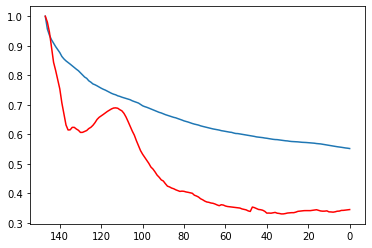

In [68]:

plt.plot(average_boot)
plt.plot(average_vis,c='red')
plt.plot(average_invis,c='yellow')
plt.gca().invert_xaxis()